In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import altair as alt

import scipy.cluster.hierarchy as hc

import rdatasets  as rds
from sklearn.datasets import load_iris, load_wine, fetch_olivetti_faces, load_digits, make_blobs, make_moons

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from sklearn.metrics import rand_score, adjusted_rand_score, silhouette_score, silhouette_samples, adjusted_mutual_info_score, normalized_mutual_info_score, confusion_matrix, ConfusionMatrixDisplay, pair_confusion_matrix

# Clustering Algorithms: K-Means, Hierarchical, and DBSCAN

Clustering is an unsupervised learning technique that groups data points into clusters such that points in the same cluster are more similar to each other than to those in different clusters. In this lecture I am going to provide a comprehensive overview of three popular clustering algorithms: 

1. **K-Means**
2. **Hierarchical Clustering**, and
3. **DBSCAN**

I am going to cover their theoretical foundations, mathematical derivations, real-world applications, comparisons of their strengths/weaknesses, and example Python implementations. The aim is to deepen understanding of how these algorithms work and when to use each.

## Theoretical Background

Clustering algorithms can be broadly categorized by their approach to forming clusters. **K-Means** is a **partitioning** method that explicitly partitions the dataset into *k* clusters by iteratively refining cluster centers. **Hierarchical clustering** builds a tree of clusters (a dendrogram) either by successive merges (agglomerative) or splits (divisive), without needing to pre-specify the number of clusters. **DBSCAN** (Density-Based Spatial Clustering of Applications with Noise) is a **density-based** method that groups points by areas of high density and identifies outliers in sparse regions ([DBSCAN - Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Density,2)).

### K-Means Clustering (Partitioning Method)

K-Means is one of the most widely used clustering algorithms. It assumes clusters are roughly spherical in the feature space and tries to find cluster centers (centroids) that minimize the distances of points to their nearest center. References: "[Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=Different%20clustering%20algorithms%20show%20varied,of%20the%20clusters%20they%20form)" and "[A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)."

The algorithm is typically implemented via **Lloyd’s iterative method**, which alternates between two steps:

1. **Assignment Step**: Assign each data point to the nearest cluster centroid (often using Euclidean distance).
2. **Update Step**: Recompute each centroid as the mean of all points assigned to that cluster.

These two steps repeat until convergence (no change in assignments or centroids). This procedure is guaranteed to decrease the clustering objective at each iteration and will converge to a local minimum of the cost function (though not necessarily the global minimum, as the optimization problem is NP-hard in general ([Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=Finding%20the%20optimal%20solution%20to,observations%20in%20d%20dimensions%20is))). The result is a partition of the data into *k* clusters with their respective centroids.

**Intuition**: The centroid (mean) represents the “center of mass” of points in a cluster, so re-centering at the mean minimizes the within-cluster variance. Each iteration refines the clusters: the assignment step creates clusters based on current centroids, and the update step shifts centroids to better fit those clusters. K-Means tends to produce convex (approximately spherical) clusters and may struggle with complex shapes or clusters of very different sizes.

### Hierarchical Clustering (Agglomerative Method)

Hierarchical clustering creates a hierarchy of cluster groupings, often visualized as a **dendrogram**. The most common approach is **agglomerative hierarchical clustering**, which is a bottom-up method:

- Start with each data point as its own cluster.
- Iteratively merge the two “closest” clusters until only one cluster remains (or a stopping criterion is met).

The definition of “closest” cluster is determined by a **linkage criterion**, which is a rule for computing distance between clusters from the distances between their points 
([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=Hierarchical%20clustering%27s%20primary%20concern%20is,clusters%20are%20merged%20or%20split)). Common linkage criteria include:

- **Single Linkage** (minimum distance): distance between two clusters = smallest distance between any single point in one cluster and any point in the other. This can result in elongated or “chained” clusters ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=nature%20allows%20it%20to%20adapt,might%20be%20intertwined%20or%20elongated)).
- **Complete Linkage** (maximum distance): distance = largest distance between any point in one cluster and any point in the other, tending to produce more compact, spherical clusters ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=For%20hierarchical%20clustering%2C%20the%20shape,create%20more%20compact%2C%20rounder%20clusters)).
- **Average Linkage** (mean distance): distance = average pairwise distance between points in the two clusters.
- **Ward’s Method** (minimum variance): merges clusters that result in the smallest increase in overall within-cluster variance (i.e., minimizes the sum of squared deviations from cluster centroids at each merge).

Hierarchical clustering does **not require specifying the number of clusters *a priori***. Instead, one can “cut” the dendrogram at a chosen level to obtain a desired number of clusters or select clusters based on a distance threshold. This flexibility is useful for exploring data at multiple granularity levels ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=In%20hierarchical%20clustering%2C%20the%20dendrogram,in%20determining%20the%20cluster%20count)). Hierarchical methods can use **any distance metric** (Euclidean, Manhattan, etc.), making them versatile in handling different data types (even a custom distance matrix) ([Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering#:~:text=Hierarchical%20clustering%20has%20the%20distinct,citation%20needed)). However, they are greedy: once a merge is done, it cannot be undone, which may lead to suboptimal clusters if a poor merge happens early. Agglomerative clustering is deterministic for a given distance metric and linkage criterion, yielding the same clustering each run.

### DBSCAN (Density-Based Method)

DBSCAN is a density-based clustering approach that discovers clusters of arbitrary shape ([A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)) and identifies points that lie alone in sparse areas as **noise** ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Density,2)). It was introduced by Ester, Kriegel, Sander, and Xu in 1996 ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Density,2)). DBSCAN requires two parameters: **ε (epsilon)** – the radius of the neighborhood to consider around a point, and **MinPts** – the minimum number of points required in an ε-neighborhood for a point to be considered a core point.

The algorithm works as follows:

- **Core Points**: If a point has at least MinPts points (including itself) within distance ε, it is labeled a *core point* ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=purpose%20of%20DBSCAN%20clustering%2C%20the,points%20and%20outliers%2C%20as%20follows)). These points lie in dense regions.
- **Direct Reachability**: A point *q* is directly reachable from a core point *p* if *q* is within ε of *p*. In other words, *q* is in the neighborhood of *p*. Only core points can directly reach other points; by definition, non-core points cannot act as sources of reachability ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=match%20at%20L394%20Reachability%20is,Therefore%2C%20a%20further%20notion%20of)).
- **Reachability**: A point *q* is reachable from *p* if there exists a chain of points $p \to p_1 \to p_2 \to \cdots \to p_n \to q$ where each point is directly reachable from the previous one. This implies *p* must be a core point and all intermediate points in the chain are core points as well ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=core%20point%20p,the%20path%20must%20be%20core)).
- **Cluster Formation**: Any core point forms a cluster with all points (core or non-core) that are reachable from it. Non-core points in a cluster are often called *border points* – they are not dense in themselves but lie in the neighborhood of a core point. Points that are not reachable from any core point are labeled as *outliers* or *noise* ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Now%20if%20p%20is%20a,used%20to%20reach%20more%20points)).

In essence, DBSCAN finds clusters by growing regions from core points: it picks an arbitrary point, finds its ε-neighborhood, and if that neighborhood has MinPts or more points (core), a new cluster is started and expanded by recursively adding all points reachable from these core points. The process repeats until all points are either assigned to a cluster or marked as noise.

**Intuition**: Clusters are seen as areas of the dataset with a higher density of points than the remainder of the dataset. DBSCAN is well-suited for datasets where clusters are irregularly shaped (not necessarily convex) and where we want to detect and exclude outliers rather than force every point into a cluster ([A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)) ([A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Handling%20Outliers)). It does not require specifying the number of clusters in advance; the number of clusters emerges from the data given the density parameters ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=DBSCAN%20inherently%20determines%20the%20number,the%20clustering%20structure%20is%20unknown)). However, choosing appropriate ε and MinPts is important – too large an ε or too low a MinPts can merge distinct clusters, while too strict parameters can leave the data fragmented or label too many points as noise.

## Mathematical Derivations

This section delves into the mathematical foundations of the algorithms, including objective functions and derivations for how clusters are formed or evaluated.

### K-Means: Objective Function and Optimization

**Objective Function:** K-Means clustering aims to find cluster assignments and centroids that minimize the *within-cluster sum of squared distances*. Formally, given a set of data points $X = \{\mathbf{x}_1, \mathbf{x}_2, \dots, \mathbf{x}_n\}$ in $\mathbb{R}^d$ and a chosen number of clusters $k$, the goal is to find sets $C_1, C_2, \dots, C_k$ (a partition of $\{1,\dots,n\}$) and centroids $\boldsymbol{\mu}_1, \dots, \boldsymbol{\mu}_k$ that minimize:

$$
J = \sum_{j=1}^{k} \sum_{i \in C_j} \|\mathbf{x}_i - \boldsymbol{\mu}_j\|^2,
$$

where $\|\mathbf{x}_i - \boldsymbol{\mu}_j\|^2$ is the (squared) distance between point $\mathbf{x}_i$ and the centroid of cluster $j$. This cost function $J$ is often called the **within-cluster sum of squares (WCSS)** or distortion. It measures cluster compactness; lower values indicate tighter clusters around their centroids.

**Optimization by Alternating Minimization:** Solving this minimization exactly is NP-hard in general ([Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering#:~:text=Finding%20the%20optimal%20solution%20to,observations%20in%20d%20dimensions%20is)), but the K-Means algorithm finds a local minimum by alternating between two partial optimizations:

- **Given centroids $\{\boldsymbol{\mu}_j\}$, assign each point to the nearest centroid:**  
  For each $i$, find cluster index $j$ that minimizes $\|\mathbf{x}_i - \boldsymbol{\mu}_j\|$. This is assigning $i$ to its closest center. This step optimally assigns points to clusters for the current centroids (it’s minimizing $J$ with centroids fixed).

- **Given assignments $C_1,\dots,C_k$, recompute each centroid as the mean of its cluster:**  
  For each cluster $j$, update $\boldsymbol{\mu}_j = \frac{1}{|C_j|}\sum_{i \in C_j} \mathbf{x}_i$. This choice minimizes $J$ for fixed assignments because the mean is the point that minimizes the sum of squared distances to points in the cluster (derivation: set $\partial J/\partial \boldsymbol{\mu}_j = 0$ yields $\boldsymbol{\mu}_j = \frac{1}{|C_j|}\sum_{i \in C_j} \mathbf{x}_i$).

These updates monotonically decrease (or at least do not increase) the objective $J$ ([Link](http://www.cs.yale.edu/homes/el327/datamining2013aFiles/10_k_means_clustering.pdf#:~:text=end%20while%20This%20algorithm%20can,X%20i%E2%88%88Sj%20kxi%20%E2%88%92%20%C2%B5jk)) ([Link](http://www.cs.yale.edu/homes/el327/datamining2013aFiles/10_k_means_clustering.pdf#:~:text=fixed%2C%20the%20best%20assignment%20is,S)). Specifically, the assignment step guarantees the closest-centroid assignment is optimal for that iteration, and the update step guarantees the new centroid is optimal for the assigned points. Thus, $J$ decreases until convergence. In practice, K-Means typically converges in a reasonable number of iterations. The final solution is a (local) minimum of $J$. 

**Distance Metric:** Standard K-Means uses Euclidean distance, which leads to the mean as the optimal centroid update. If a different distance (e.g., Manhattan) is used, the update would use the corresponding median instead of mean.

**Result of Optimization:** The output is a set of centroids $\{\boldsymbol{\mu}_1, \dots, \boldsymbol{\mu}_k\}$ and cluster labels for each point (indicating which $C_j$ it belongs to). The clustering partitions the space into Voronoi regions around each centroid. The sum of squared distances $J$ can be used to evaluate cluster compactness. (One may also compute the **between-cluster sum of squares** to evaluate separation, or use **silhouette scores** for assessing clustering quality, though those are beyond the K-Means algorithm itself.)

### Hierarchical Clustering: Linkage Distance Calculations

Hierarchical agglomerative clustering requires computing distances between clusters at each merge. If we have a distance (dissimilarity) function $d(p,q)$ defined between individual points $p$ and $q$, we need to extend it to define distance between a set of points $A$ (cluster) and another set $B$ (cluster). The **linkage criteria** are mathematical definitions of this inter-cluster distance. Table 1 summarizes common linkage formulas, where $A$ and $B$ are two clusters, and $|A|$ denotes the number of points in cluster $A$:


| **Linkage Criterion**        | **Distance Between Cluster $A$ and $B$**                                        | **Characteristics**                   |
|------------------------------|---------------------------------------------------------------------------------|---------------------------------------|
| **Single Linkage**           | $d_{\min}(A,B) \;=\; \min_{a \in A,\;b \in B} \; d(a,b)$                        | Nearest points determine cluster distance. Can form *chain-like* clusters (good for arbitrary shapes, but sensitive to noise). |
| **Complete Linkage**         | $d_{\max}(A,B) \;=\; \max_{a \in A,\;b \in B} \; d(a,b)$                        | Farthest points determine distance. Tends to produce *compact, spherical* clusters (limits chaining). |
| **Average Linkage**          | $d_{\text{avg}}(A,B) \;=\; \frac{1}{|A|\,|B|}\sum_{a\in A}\sum_{b\in B} d(a,b)$ | Uses average pairwise distance between points of clusters. Balanced, not as sensitive to outliers as single/complete. |
| **Ward’s Method (Min Var)**  | $d_{\text{Ward}}(A,B) \;=\; \frac{|A|\,|B|}{|A| + |B|} \;\| \boldsymbol{\mu}_A - \boldsymbol{\mu}_B \|^2$           | Distance = increase in SSE when merging $A$ and $B$. Merges minimize variance within clusters, akin to K-Means objective at each step. |

*Table 1: Common linkage criteria in agglomerative hierarchical clustering, with their formulas and characteristics.* ([Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering#:~:text=Maximum%20or%20complete,a%5Cin%20A%2C%5C%2Cb%5Cin%20B%7Dd%28a%2Cb)) ([Wikipedia](https://en.wikipedia.org/wiki/Hierarchical_clustering#:~:text=Ward%20linkage%2C,sum))

At the start of agglomerative clustering, each data point is its own cluster. The algorithm then repeatedly merges the pair of clusters with the smallest inter-cluster distance (according to the chosen linkage) until one cluster remains or a stopping condition. The result can be represented as a binary tree of merges (dendrogram). To obtain $m$ clusters, one can cut the dendrogram at a height that leaves $m$ clusters. Notably, single linkage clustering has a theoretical connection to the minimum spanning tree: if one cuts a single-linkage dendrogram at distance $\epsilon$, the clusters correspond to connected components in a graph where edges connect points within $\epsilon$ distance – this equivalence means single linkage effectively finds any-shaped clusters similar to a thresholded MST (but it is also prone to “chaining” effects where clusters can become straggly). Complete linkage, by contrast, ensures all points in a cluster are relatively close, avoiding chaining at the cost of possibly breaking true clusters that have slight chaining connections. Ward’s method is effectively a greedy top-down approximation to K-Means: it tries to minimize the total within-cluster variance at each merge.

### DBSCAN: Density Reachability and Core Point Conditions

DBSCAN’s mathematical foundation is based on the notion of ε-neighborhoods and density reachability:

- **ε-Neighborhood**: For a point $p$, the $\epsilon$-neighborhood is $N_{\epsilon}(p) = \{ q \mid d(p,q) \le \epsilon \}$ (using a chosen distance metric, often Euclidean). This is the set of points within distance ε of $p$ (including $p$ itself).

- **Core Point Criterion**: $p$ is a *core point* if $|N_{\epsilon}(p)| \ge \text{MinPts}$. In other words, there are at least MinPts points (typically counting $p$ itself in that total) within distance ε of $p$ ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=purpose%20of%20DBSCAN%20clustering%2C%20the,points%20and%20outliers%2C%20as%20follows)). MinPts is usually chosen >= 3 (if MinPts = 1 or 2, every point tends to become core or it reduces to something like single-linkage clustering ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=match%20at%20L610%20does%20not,are%20usually%20better%20for%20data))).

- **Direct Density Reachable**: A point $q$ is directly density-reachable from $p$ if $p$ is a core point and $q \in N_{\epsilon}(p)$ (i.e., $d(p,q)\le \epsilon$). Note this relation is not symmetric; $q$ could be reachable from $p$ even if $q$ is not a core point (reachable *to* $q$) ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=match%20at%20L394%20Reachability%20is,of%20the%20clusters%20found%20by)).

- **Density Reachable (Transitive Closure)**: $q$ is density-reachable from $p$ if there exists a sequence of points $p = p_0, p_1, ..., p_m = q$ such that $p_{i+1}$ is directly density-reachable from $p_i$ for all $0 \le i < m$. This implies $p_0$ must be a core point, and each link in the chain $p_i \to p_{i+1}$ goes from a core point to one of its neighbors. In effect, $q$ lies within a chain of neighboring dense regions starting from $p$.

- **Density-Connected**: Two points $p$ and $q$ are density-connected if there exists a third point $o$ such that *both* $p$ and $q$ are density-reachable from $o$. This defines a connectivity relation among points via dense regions.

Using these definitions, DBSCAN defines a *cluster* as a set of points that are all density-connected to each other (there will always be at least one core point in a cluster to serve as a nucleus). Any point not belonging to any cluster is labeled as noise. Formally, one can show that for a given ε and MinPts, DBSCAN produces clusters that satisfy a maximality property: if a point is density-reachable from any point of a cluster, it is part of that cluster. And each cluster contains at least one core point, and all core points in a cluster are mutually density-connected ([Wikipedia](https://en.wikipedia.org/wiki/DBSCAN#:~:text=Now%20if%20p%20is%20a,used%20to%20reach%20more%20points)).

**Density Estimation vs Parameter Choice**: DBSCAN does not explicitly estimate a *numeric density* like a probability density function; instead, ε and MinPts define a cutoff for density (a *region is dense* if it contains MinPts points in an ε radius). In practice, choosing ε is often aided by a *k-distance graph* (plotting the distance to the k-th nearest neighbor for each point, sorted by those distances, and looking for an “elbow” that suggests a natural distance threshold for clustering). MinPts is often set to a small integer (e.g., 4 or 5 for 2D data, higher for higher dimensions) based on domain knowledge or guidelines (a common rule of thumb is MinPts = 2 * dim, but at least 3) ([A Guide to the DBSCAN Clustering Algorithm](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=We%20use%20scikit)).

The time complexity of a naive DBSCAN implementation is $O(n^2)$ (checking each point’s ε-neighborhood by scanning all points). However, with spatial index structures (like k-d trees or ball trees for low-dimensional data), the average complexity can approach $O(n \log n)$ ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=DBSCAN%2C%20while%20linear%20in%20nature%2C,search%2C%20making%20DBSCAN%20more%20scalable)). DBSCAN can be less efficient in very high dimensions (where indexing is hard and distances become less meaningful due to the curse of dimensionality) or if the data is such that almost all points end up in one cluster (worst-case $O(n^2)$ if every point is a neighbor to many others). 

## Comparisons of K-Means, Hierarchical, and DBSCAN

Each of these algorithms has its own strengths and weaknesses. The best choice depends on the dataset characteristics and the goals of analysis. Table 2 provides a high-level comparison:

| **Aspect**              | **K-Means**                                              | **Hierarchical**                                            | **DBSCAN**                                                            |
|-------------------------|----------------------------------------------------------|-------------------------------------------------------------|-----------------------------------------------------------------------|
| **Cluster Shape Bias**  | Prefers convex (spherical) clusters ([A Guide to the DBSCAN Clustering Algorithm at DataCamp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)).       | Depends on linkage: single linkage can find elongated clusters; complete/average/ward favor compact clusters. | Can find clusters of arbitrary shape ([A Guide to the DBSCAN Clustering Algorithm at DataCamp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Cluster%20Shape)) (density-connected arbitrary regions). |
| **# of Clusters**       | Must specify $k$ in advance.                             | No need to pre-specify; produces a full dendrogram. Choose clusters by cutting tree ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods at Hex ](https://hex.tech/blog/comparing-density-based-methods/#:~:text=In%20hierarchical%20clustering%2C%20the%20dendrogram,in%20determining%20the%20cluster%20count)). | No need to specify *k*; number of clusters determined by ε & MinPts (algorithm finds however many dense clusters exist). |
| **Handling Outliers**   | No explicit notion of outliers – all points get assigned to some cluster. Outliers can skew centroids. | No explicit outlier handling – eventually every point will merge into the hierarchy (though one can manually cut the dendrogram to isolate small clusters as outliers). | Explicitly identifies noise points that do not belong to any cluster ([A Guide to the DBSCAN Clustering Algorithm at DataCamp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=Handling%20Outliers)). Outliers remain unassigned rather than distorting clusters. |
| **Scalability**         | Highly scalable: time complexity roughly $O(n \cdot k \cdot t)$ for $t$ iterations (often linear in $n$). Works well even on large datasets; the most costly part is distance computations, which can be accelerated. | Not very scalable: typically $O(n^2)$ (or $O(n^2 \log n)$ with optimizations ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=Hierarchical%20clustering%2C%20particularly%20the%20agglomerative,DBSCAN%20for%20very%20large%20datasets))) time and $O(n^2)$ memory for agglomerative clustering. Practical for smaller datasets (up to a few thousands or tens of thousands of points). | Moderately scalable: average $O(n \log n)$ with indexing, but worst-case $O(n^2)$. Performs well on medium-sized data; struggles if data is extremely large or high-dimensional without efficient indexing ([Comparing DBSCAN, k-means, and Hierarchical Clustering: When and Why To Choose Density-Based Methods](https://hex.tech/blog/comparing-density-based-methods/#:~:text=DBSCAN%2C%20while%20linear%20in%20nature%2C,search%2C%20making%20DBSCAN%20more%20scalable)). |
| **Determinism**        | Non-deterministic: random initialization means results can vary (mitigate by multiple runs or k-means++ initialization for consistency). | Deterministic: given the same distance matrix and linkage, always produces the same clusters (no randomness). | Deterministic: clustering result is the same each run (order of processing may vary but end clusters are stable, assuming no tie-breaking issues). |
| **Parameter Sensitivity** | Must choose $k$; results also depend on initialization (which is why k-means++ is used to improve start) and the distance metric. | Must choose a linkage criterion (and distance metric); different choices can yield different cluster structures. Also need to decide where to cut the dendrogram for a final clustering. | Must choose ε and MinPts; a poor choice can lead to under- or over-clustering. Parameter selection is aided by heuristics like the k-distance plot. |
| **When Best to Use**   | When you have a rough idea of number of clusters and data is numeric, reasonably convex clusters. Excellent for large datasets where $k$ is not too large. Example: market segmentation, quick partitioning tasks. | When hierarchical relationships or dendrogram insight is desired, or when the number of clusters is completely unknown (dendrogram can suggest an appropriate $m$). Good for smaller datasets, exploratory analysis, or when any distance metric (not just Euclidean) is required. Example: taxonomies, gene clustering. | When clusters are irregularly shaped or you expect meaningful noise/outliers. Also when the number of clusters is unknown and you prefer the algorithm to discover it. Great for spatial data, anomaly detection. Example: clustering geographic data points, finding communities in point clouds, filtering out noise in sensor data. |

*Table 2: Comparison of K-Means, Hierarchical Clustering, and DBSCAN on key aspects.* 

In summary, **K-Means** is fast and simple but requires spherical-like clusters and a predefined $k$; **Hierarchical clustering** is flexible and gives a full spectrum of possible clusters but doesn’t scale well and has no built-in noise handling; **DBSCAN** is powerful for unusual cluster shapes and filtering out noise but can be less effective if clusters have varying densities or if parameters are not tuned well. Often, one might try multiple methods to see which yields the most meaningful grouping for the task at hand.


## Real-World Applications

Clustering is applied in many domains to discover inherent groupings in data. Below are a few notable applications for K-Means, hierarchical clustering, and DBSCAN:

- **Customer Segmentation (Marketing/Business)**: Companies often use clustering to segment customers based on purchasing behavior, demographics, or engagement. **K-Means** is a popular choice for customer segmentation since it efficiently handles large datasets and yields interpretable cluster centroids (e.g., the “average” customer profile for each segment). Marketers can target different clusters with tailored strategies. For example, an e-commerce site might cluster users by their browsing and buying patterns to identify “bargain shoppers,” “loyal customers,” “window shoppers,” etc. Hierarchical clustering can also be used on smaller customer datasets to reveal a hierarchy of segments (which might show sub-segments within a broad cluster, for instance). **DBSCAN** is less used in this domain unless one is specifically looking for outlier detection – for instance, to find unusual customers (potential fraud or extraordinary high-value customers) that don’t belong to any large segment, since DBSCAN would mark them as noise.

- **Image Processing and Computer Vision**: Clustering is fundamental in tasks like image segmentation, compression, and feature grouping. **K-Means** is famously used for color quantization in image compression/segmentation: by clustering the RGB values of pixels into *k* clusters, an image can be represented using *k* representative colors (centroids) which simplifies the image while preserving its general appearance. This is effectively compressing the color space. It is also used to cluster image patches or features for texture segmentation. **Hierarchical clustering** can be applied in image processing when a multi-scale representation is needed; for example, in clustering images or features to form a hierarchical taxonomy of image categories, or in gene expression heatmaps in bioinformatics (which are often visualized with hierarchical clustering of both genes and conditions). **DBSCAN** is useful in computer vision for clustering spatial coordinates of image features – for instance, clustering keypoint descriptors in an image to find groups of interest points that correspond to an object. DBSCAN’s ability to find arbitrary shaped clusters is handy when looking for contiguous regions of pixels of similar intensity or color in an image without assuming convexity. In satellite imagery analysis or blob detection, DBSCAN can find clusters of pixels (or objects in the image) and also identify noise points (isolated pixels) that should be ignored.

- **Bioinformatics**: Clustering techniques are heavily used to make sense of biological data. A common use of **hierarchical clustering** is in gene expression analysis: researchers measure expression levels of thousands of genes across different conditions or time points, then cluster genes with similar expression patterns. Hierarchical clustering (with average linkage, for example) produces a dendrogram that groups genes by expression similarity, which can reveal functional groupings or co-regulated genes. The result is often visualized as a heatmap with an accompanying dendrogram. **K-Means** is also used in bioinformatics for clustering gene expression profiles or protein sequences (after embedding sequences into feature vectors), especially when a fixed number of clusters is expected or for large datasets where hierarchical methods are too slow. **DBSCAN** has applications in clustering proteins or small molecules based on 3D structure or chemical properties, where clusters might have irregular shapes in feature space. It’s also useful in flow cytometry data analysis, where clusters of cells in high-dimensional marker space correspond to cell populations – DBSCAN can identify these populations and flag rare cell types as outliers. Moreover, DBSCAN’s ability to label noise is useful in high-throughput biological data that often contains experimental artifacts or junk events.

- **Anomaly Detection**: While not a domain per se, it’s worth noting that DBSCAN is often used for anomaly or outlier detection in various contexts (network security, finance, etc.). Because DBSCAN will label isolated points as noise, one can apply DBSCAN to e.g. network traffic data, transaction data, or sensor data to find clusters of typical behavior and automatically detect anomalies as those points not assigned to any cluster. K-Means is less directly suited to this because it forces every point into a cluster, but sometimes small clusters or clusters with high distance can indicate anomalies in K-Means as well. Hierarchical clustering can also be used to detect outliers by observing single-element clusters at certain cut distances.

These examples illustrate how the choice of clustering algorithm can depend on the context: K-Means excels when clusters are roughly spherical and a quick, efficient partition is needed (as in large customer databases or image pixel clustering); hierarchical clustering is useful when a nested grouping structure is of interest or when the number of clusters is unknown and one wants the flexibility to decide after seeing the hierarchy (common in research and exploratory data analysis, like gene clustering); DBSCAN is advantageous when looking for oddly-shaped clusters or when distinguishing noise is important (as in spatial data or anomaly detection).

## Two Simple Toy Examples

Below are examples of how to implement and use K-Means, hierarchical clustering, and DBSCAN in Python, using popular libraries `numpy` and `scikit-learn`. We will generate a simple dataset for illustration and then apply each algorithm. (Note: In practice, you would use real datasets; here we use synthetic data for clarity.)

### Example Synthetic Dataset

First, let's create a synthetic dataset to cluster. We will generate two different scenarios to showcase the algorithms:

- A blob of points suitable for K-Means and hierarchical clustering (three Gaussian clusters in 2D).
- A two-moons dataset (two interleaving half-circle shapes) with a few noise points, to demonstrate DBSCAN’s ability to find non-convex clusters and identify outliers.

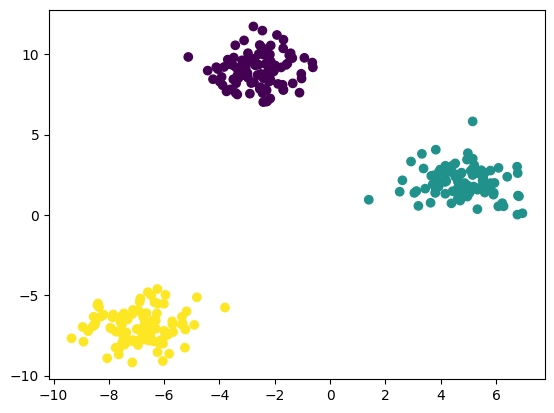

In [2]:
# Create 3 blobs of points (Gaussian clusters) in 2D for K-Means/Hierarchical
X_blobs, y_blobs = make_blobs(n_samples=300, centers=3, cluster_std=1.0, random_state=42)
plt.scatter(X_blobs[:,0],X_blobs[:,1], c=y_blobs)

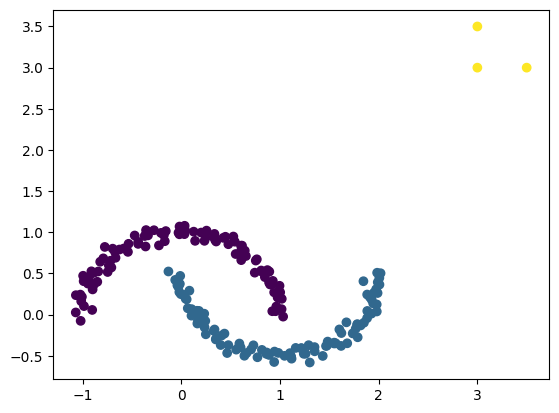

In [3]:
# Create two moons dataset for DBSCAN, with some noise added
X_moons, y_moons = make_moons(n_samples=200, noise=0.05, random_state=0)

# Add a few outlier points far away from the moons
X_outliers = np.array([[3, 3], [3.5, 3], [3, 3.5]])
X_moons_out = np.vstack([X_moons, X_outliers])

y_outliers = np.array([3, 3, 3])
y_moons_out = np.hstack([y_moons, y_outliers])

plt.scatter(X_moons_out[:,0], X_moons_out[:,1], c=y_moons_out)

In the code above, `X_blobs` contains 300 points forming three clusters in 2D (useful for K-Means and hierarchical clustering demonstrations). `X_moons_out` contains 200 points in a two-moon shape plus 3 outliers far off from the main clusters (useful for demonstrating DBSCAN’s noise handling).

### K-Means Clustering in Python

We use `sklearn.cluster.KMeans` to perform K-Means clustering on the blob dataset. We will assume we know there are 3 clusters and set `n_clusters=3`. We also set `n_init=10` for more robust centroid initialization (scikit-learn uses K-Means++ by default for centroid initialization).

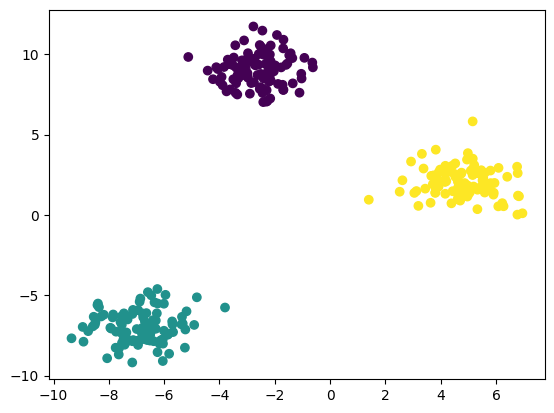

In [4]:
kmeans = KMeans(n_clusters=3, n_init=10, random_state=0)
labels_km = kmeans.fit_predict(X_blobs)
plt.scatter(X_blobs[:,0], X_blobs[:,1], c=labels_km)

**Explanation:** 

After fitting, `kmeans.cluster_centers_` contains the coordinates of the 3 centroids found. `labels_km` is an array of cluster indices (0, 1, or 2) assigned to each point in `X_blobs`. The `inertia_` attribute is the final WCSS (sum of squared distances of points to their cluster center). We print the first 10 labels to see an example of assignments.

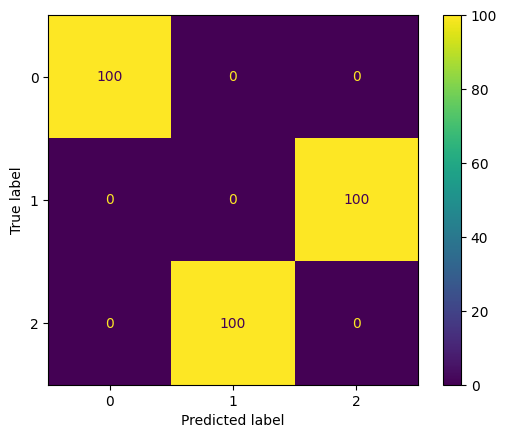

In [5]:
ConfusionMatrixDisplay.from_predictions(y_blobs,labels_km)

### Hierarchical Agglomerative Clustering in Python

Scikit-learn provides `AgglomerativeClustering` for hierarchical clustering. We will cluster the same blob data. Since we know there are 3 natural clusters, we set `n_clusters=3` for a fair comparison (though in practice one might look at the dendrogram to decide this). We can specify a linkage; by default scikit-learn uses Ward’s method (which tends to produce clusters similar to K-Means if clusters are roughly Gaussian), but we could choose `'single'`, `'complete'`, or `'average'` via the `linkage` parameter.

The labels coming from hiearchical clustering might coincide with the K-Means labels in this case (by chance of how labels are numbered) – both identified the natural clusters. 

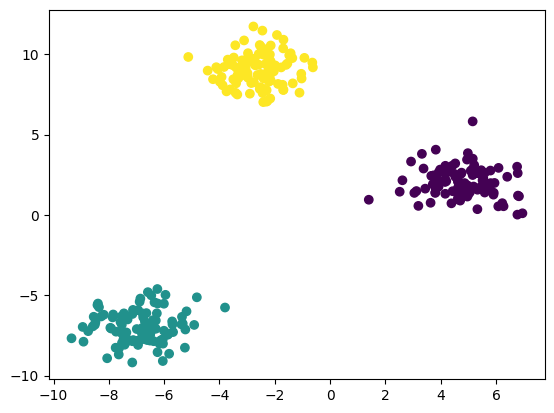

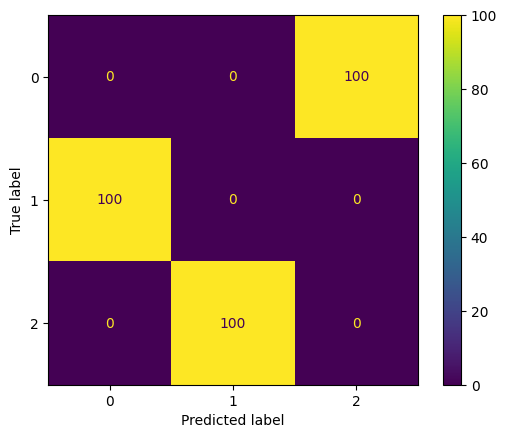

In [6]:
agg = AgglomerativeClustering(n_clusters=3, linkage='single')
labels_hier = agg.fit_predict(X_blobs)
plt.scatter(X_blobs[:,0], X_blobs[:,1], c=labels_hier)
ConfusionMatrixDisplay.from_predictions(y_blobs,labels_hier)

**Explanation:** 

`labels_hier` will contain cluster assignments (0,1,2) for each point, corresponding to the 3 clusters found by the algorithm. The order of labels may not match K-Means, but they represent a partition of the data. We used Ward’s method; if we wanted a full dendrogram, we could use SciPy’s `linkage` function to compute the merge structure.

To illustrate obtaining a dendrogram using SciPy:

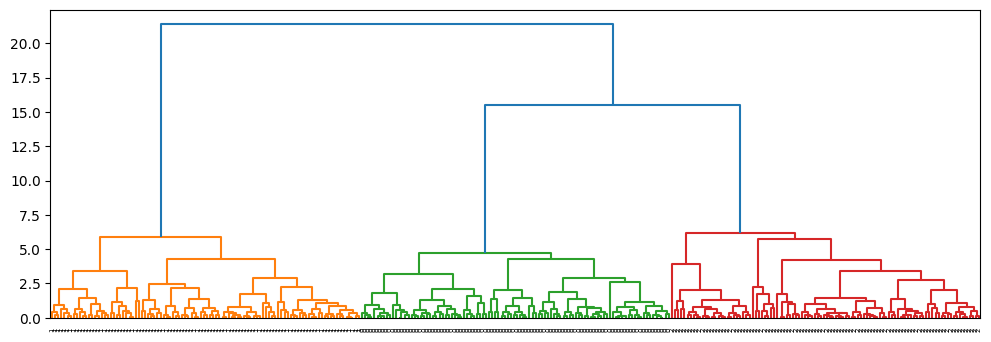

In [7]:
Z = hc.linkage(X_blobs, method='complete')
plt.figure(figsize=(12,4))
den = hc.dendrogram(Z, orientation='top',labels=labels_km)

### DBSCAN Clustering in Python

Now we apply **DBSCAN** to the two-moons dataset with outliers (`X_moons_out`). We expect DBSCAN to find 2 clusters (the two moons) and label the few far-out points as noise. We need to choose ε and MinPts. For this dataset, we know the two moons are separated by a gap, so we can choose ε around the scale of that gap. Suppose we pick `eps=0.3` and `min_samples=5` (MinPts=5):

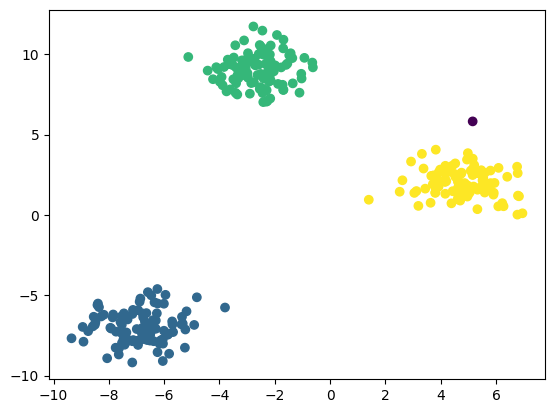

In [8]:
dbscan = DBSCAN(eps=1.5, min_samples=6)
labels_db = dbscan.fit_predict(X_blobs)
plt.scatter(X_blobs[:,0], X_blobs[:,1], c=labels_db)

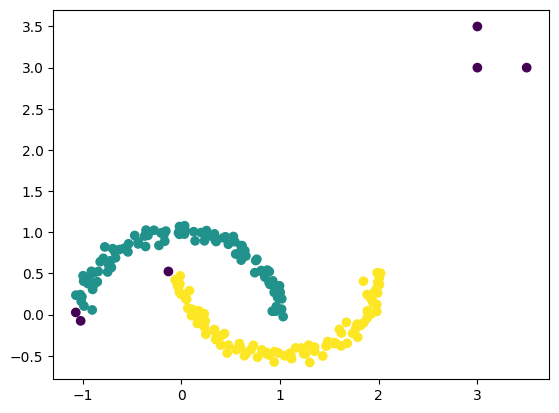

In [9]:
# Perform DBSCAN clustering on the two-moons dataset
dbscan = DBSCAN(eps=0.3, min_samples=18)
labels_db = dbscan.fit_predict(X_moons_out)

plt.scatter(X_moons_out[:,0], X_moons_out[:,1], c=labels_db)

**Explanation:** 

After fitting, `labels_db` contains cluster labels for each point in `X_moons_out`. DBSCAN labels noise as -1 by convention. So, `unique_labels` might look like `[-1, 0, 1]` meaning two clusters (0 and 1) and noise (-1). We then count how many points fell into each to see how many noise points versus clustered points.


This output indicates that DBSCAN found 2 clusters (labeled 0 and 1) and labeled 3 points as `-1` (noise). Indeed, we added 3 outlier points, and they have been detected as not belonging to any cluster. Each moon cluster has about 100 points (the original two-moons dataset had 200 points evenly split, minus any that might also be treated as noise if they fell in sparse areas on the fringes). The result demonstrates how DBSCAN can successfully identify the two moon-shaped clusters **without** having to specify the number of clusters, and it naturally excluded the isolated outliers as noise. In contrast, if we ran K-Means with k=2 on the same data, K-Means would force those outliers into one of the 2 clusters, and it might also have difficulty with the non-convex shape of the moons (potentially splitting one moon or mixing parts of both moons) ([A Guide to the DBSCAN Clustering Algorithm | DataCamp](https://www.datacamp.com/tutorial/dbscan-clustering-algorithm#:~:text=1,usually%20colored%20differently)).

### Additional Notes on Implementation

All three algorithms are available in scikit-learn and are easy to use. Key considerations when implementing:

- **Preprocessing**: Features should be scaled appropriately (especially for distance-based methods like K-Means and DBSCAN). For example, using `StandardScaler` to normalize features can improve clustering results.
- **Initialization (K-Means)**: Using `init='k-means++'` (scikit-learn default) is recommended for K-Means to get better initial centroids. We set `n_init=10` to run the algorithm 10 times and take the best result, which helps avoid unlucky initializations.
- **Linkage Choices (Hierarchical)**: Scikit-learn’s AgglomerativeClustering with `n_clusters` will not produce a full dendrogram. If a full hierarchy is needed, one can use `scipy.cluster.hierarchy` as shown. Scikit-learn does allow retrieving children of merges via the `children_` attribute of the fitted model, but visualization still requires external tools (like SciPy dendrogram or other libraries).
- **Parameter Tuning (DBSCAN)**: It’s often useful to plot the k-distance graph to choose ε. In scikit-learn, one might try multiple eps values or use domain knowledge. MinPts is usually kept fixed to a small value (e.g., 5-10).
- **Performance**: K-Means and DBSCAN can handle fairly large datasets (thousands to millions of points, depending on memory) with efficient implementations. Hierarchical clustering, due to its $O(n^2)$ memory requirement, is typically limited to at most a few tens of thousands of points (and even that can be slow).


# Real Examples
## Iris Dataset

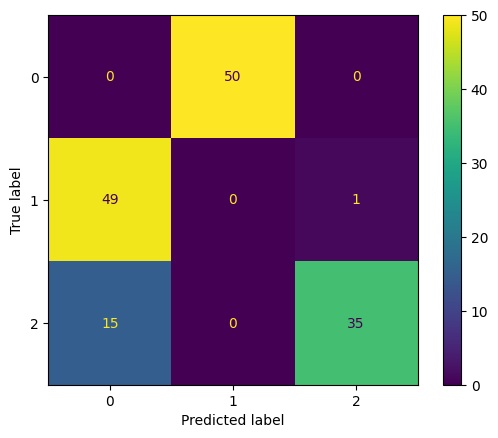

In [10]:
raw = load_iris()
X_iris = raw['data']
y_iris = raw['target']

model = AgglomerativeClustering(n_clusters=3)
model.fit(X_iris)
y_pred = model.fit_predict(X_iris)
ConfusionMatrixDisplay.from_predictions(y_iris,y_pred)

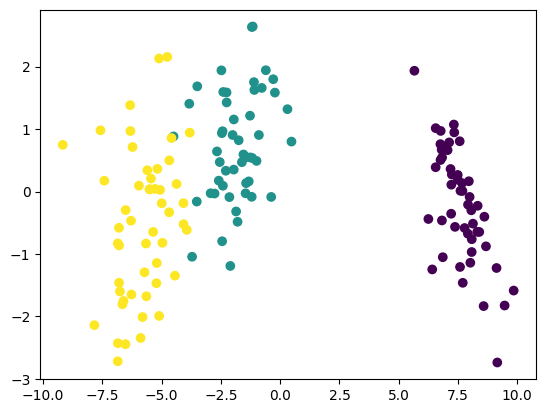

In [11]:
projector = LinearDiscriminantAnalysis(n_components=2)
Xp = projector.fit_transform(X_iris,y_iris)
plt.scatter(Xp[:,0],Xp[:,1],c=y_iris)

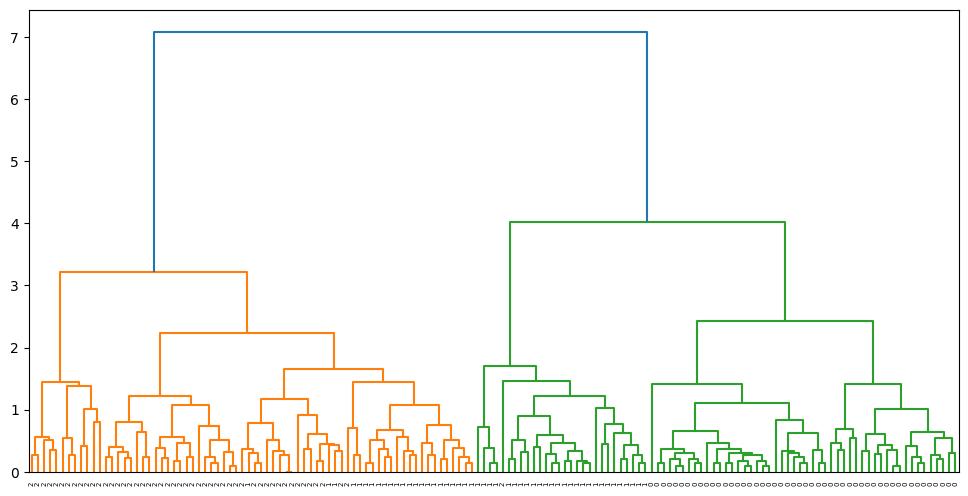

In [12]:
plt.figure(figsize=(12,6))
den = hc.dendrogram(hc.linkage(X_iris, method='complete'), orientation='top',labels=y_iris)

### USA Arrests

In [13]:
arrests = rds.data('USArrests')
arrests

,rownames,Murder,Assault,UrbanPop,Rape
0,Alabama,13.2,236,58,21.2
1,Alaska,10.0,263,48,44.5
2,Arizona,8.1,294,80,31.0
3,Arkansas,8.8,190,50,19.5
4,California,9.0,276,91,40.6
5,Colorado,7.9,204,78,38.7
6,Connecticut,3.3,110,77,11.1
7,Delaware,5.9,238,72,15.8
8,Florida,15.4,335,80,31.9
9,Georgia,17.4,211,60,25.8


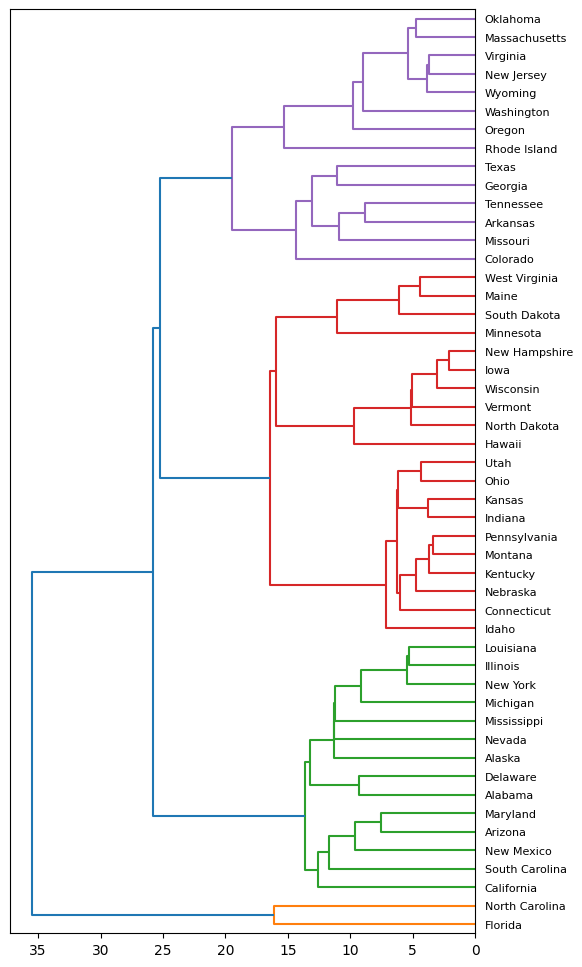

In [14]:
X = arrests[['Murder','Assault','Rape']]
y = arrests['rownames']

plt.figure(figsize=(6,12))
den = hc.dendrogram(hc.linkage(X.to_numpy(), method='single'), orientation='left',labels=y.to_numpy())

### Turkish Crime Statistics



In [15]:
raw = pd.read_excel('../data/turkiye_suc_istatistikleri_2022.xls')
data = raw[raw['Gender'].notna()]
del data['Gender'], data['Total']
data = data.replace('-',0)
data.iloc[:,1:] = data.iloc[:,1:].astype(np.int32)
data

/tmp/ipykernel_310012/2776838312.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace('-',0)


,City,Homicide,Assault,Sexual crimes,Kidnapping,Defamation,Theft,Robbery,Swindling,Drugs with intent to sell,...,Forestry crimes,Crimes with deadly weapons,Financial crimes,Military crimes,Threat,Damage to property,Resistance to arrest,Domestic dispute,Other Crimes,Unknown
0,İstanbul,1026,5055,820,811,520,6306,2023,1846,1954,...,43,1655,1230,499,916,292,563,612,6569,61
1,NaN,26,123,6,16,32,487,62,108,131,...,3,9,53,0,25,23,25,25,382,3
3,Tekirdağ,71,453,76,60,46,509,90,58,63,...,2,65,154,239,97,31,46,136,367,2
4,NaN,3,7,0,2,1,23,6,0,10,...,0,0,7,0,2,2,2,1,19,0
6,Edirne,39,260,39,28,28,226,41,38,58,...,2,32,65,200,49,11,20,30,596,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,Şırnak,11,59,7,19,5,98,10,16,16,...,0,25,4,45,18,5,15,8,214,1
238,NaN,0,1,0,0,1,3,0,1,0,...,0,0,0,0,1,0,0,0,11,0
240,Siirt,12,95,10,9,6,106,18,3,14,...,1,26,1,16,19,11,13,22,114,0
241,NaN,1,2,0,5,1,3,0,0,0,...,0,0,0,0,0,0,0,0,6,0


In [16]:
N = int((data.shape[0]-1)/2)
tmp = []
for i in range(N):
    tmp.append(data.iloc[2*i,1:]+data.iloc[2*i+1,1:])
    tmp[i] = tmp[i]/sum(tmp[i])
               
X = pd.DataFrame(tmp)
y = [data.iloc[2*i,0] for i in range(N)]

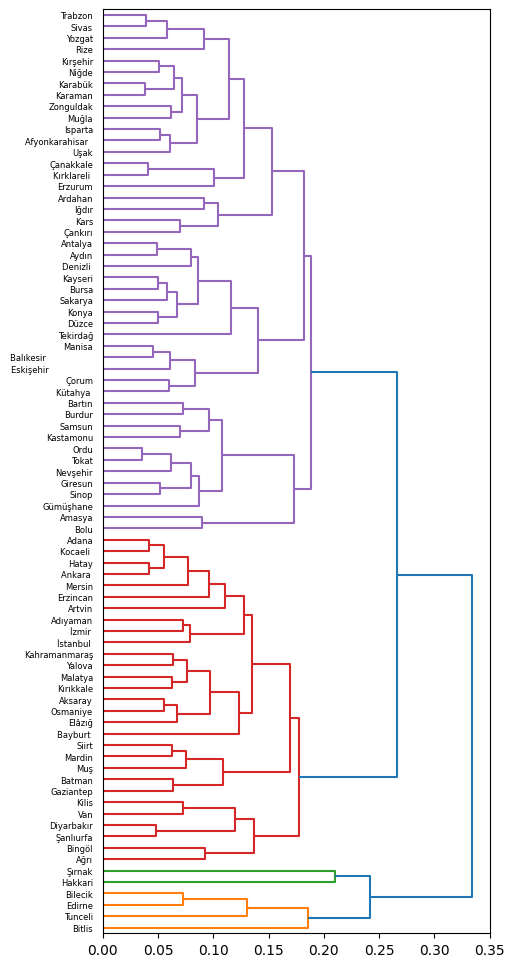

In [17]:
plt.figure(figsize=(5,12))
den = hc.dendrogram(hc.linkage(X, method='complete'), orientation='right',labels=y)

In [18]:
def interactiveDraw(xs,ys,labels,cs,size=(800,400)):
    data = pd.DataFrame({'x': xs, 'y': ys, 'label': labels, 'color': cs})
    return alt.Chart(data).mark_circle(size=100).encode(
                x='x',
                y='y',
                color=alt.Color('color').scale(scheme="dark2"),
                tooltip=['label']
            ).properties(width=size[0],
                         height=size[1]
                        ).interactive()

In [19]:
model = AgglomerativeClustering(n_clusters=3)
colors = model.fit_predict(X)
projector = LinearDiscriminantAnalysis(n_components=2)
turkey_points = projector.fit_transform(X,colors)
interactiveDraw(turkey_points[:,0],turkey_points[:,1],data.dropna().iloc[:81,0],colors,(800,500))

alt.Chart(...)

## The Wine Dataset

For this example, we are going to use the [wine dataset]() 

In [20]:
wine = load_wine()
wine_X = wine['data']
wine_y = wine['target']
pd.DataFrame(wine_X)

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95.0,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740.0
174,13.40,3.91,2.48,23.0,102.0,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750.0
175,13.27,4.28,2.26,20.0,120.0,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835.0
176,13.17,2.59,2.37,20.0,120.0,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840.0


In [21]:
projector = LinearDiscriminantAnalysis(n_components=2)
wine_points = projector.fit_transform(wine_X,wine_y)
interactiveDraw(wine_points[:,0],wine_points[:,1],wine_y,wine_y)

alt.Chart(...)

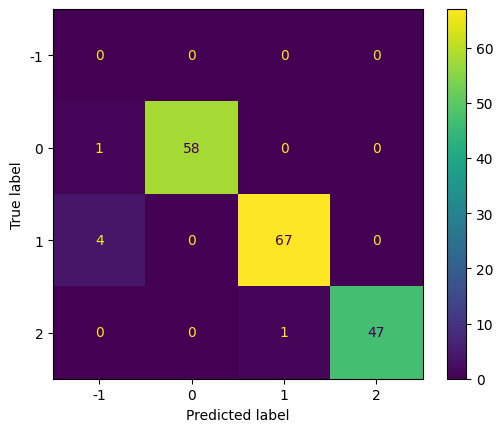

In [22]:
model = DBSCAN(eps=0.9,min_samples=5)
wine_y_pred = model.fit_predict(wine_points)
ConfusionMatrixDisplay.from_predictions(wine_y,wine_y_pred)

## MNIST Digits

In [23]:
raw = load_digits()
digits_X = raw['data']
digits_y = raw['target']
digits_y

array([0, 1, 2, ..., 8, 9, 8], shape=(1797,))

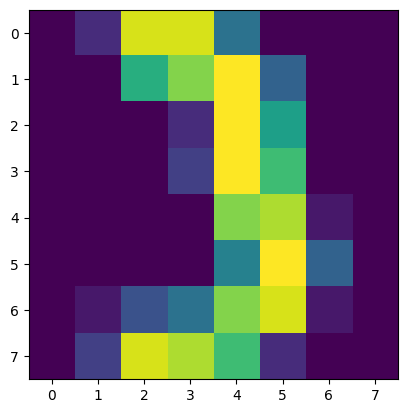

In [24]:
plt.imshow(digits_X[190,:].reshape((8,8)))

In [25]:
projector = TSNE(n_components=2)
digits_points = projector.fit_transform(digits_X,digits_y)
interactiveDraw(digits_points[:,0],digits_points[:,1],digits_y,digits_y,size=(800,500))

alt.Chart(...)

In [26]:
def displayCM(y_test,y_pred,size=(12,12)):
    disp = ConfusionMatrixDisplay.from_predictions(y_test,y_pred, display_labels=None)
    fig = disp.ax_.get_figure() 
    fig.set_figwidth(size[0])
    fig.set_figheight(size[1])  

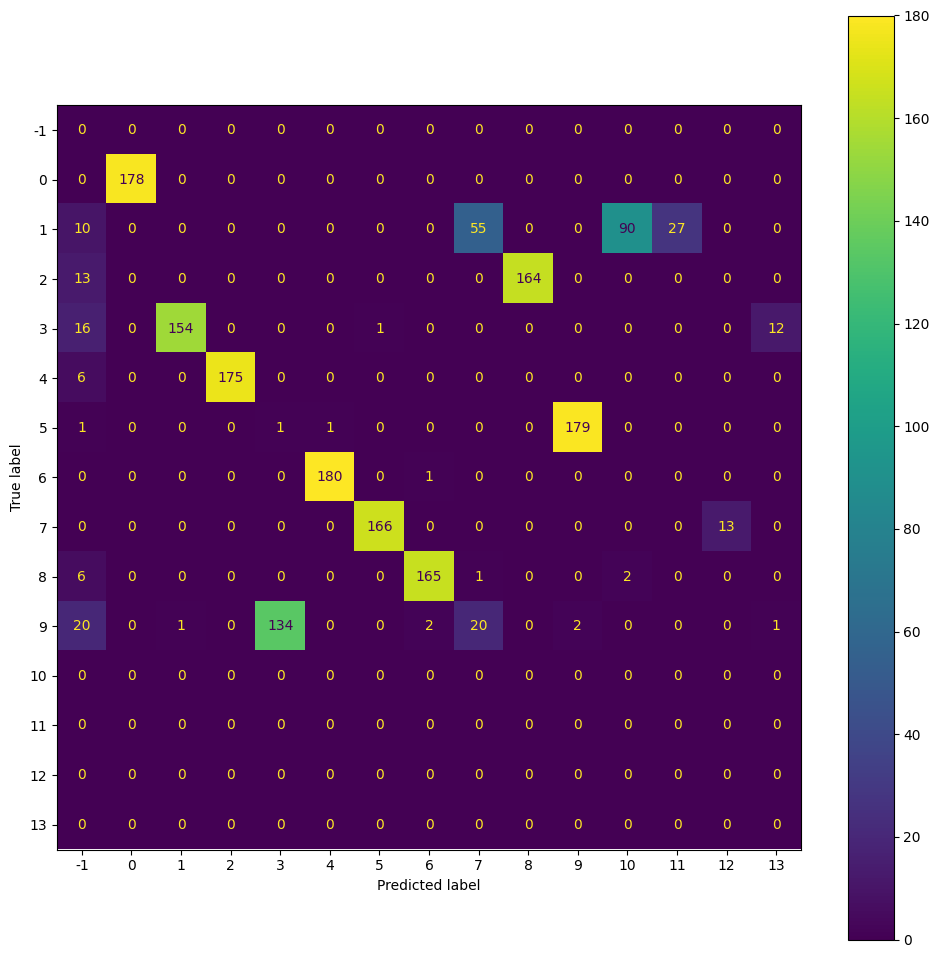

In [27]:
model = DBSCAN(eps=2.9,min_samples=13)
digits_y_pred = model.fit_predict(digits_points)
displayCM(digits_y,digits_y_pred)

## Olivetti Faces

For this example, we are going to use the Olivetti faces dataset.

In [28]:
faces = fetch_olivetti_faces()
faces_X = faces['data']
faces_y = faces['target']

In [29]:
projector = TSNE(n_components=2)
faces_points = projector.fit_transform(faces_X,faces_y)
interactiveDraw(faces_X[:,0],faces_X[:,1],faces_y,faces_y)

alt.Chart(...)

<Figure size 1000x1000 with 0 Axes>

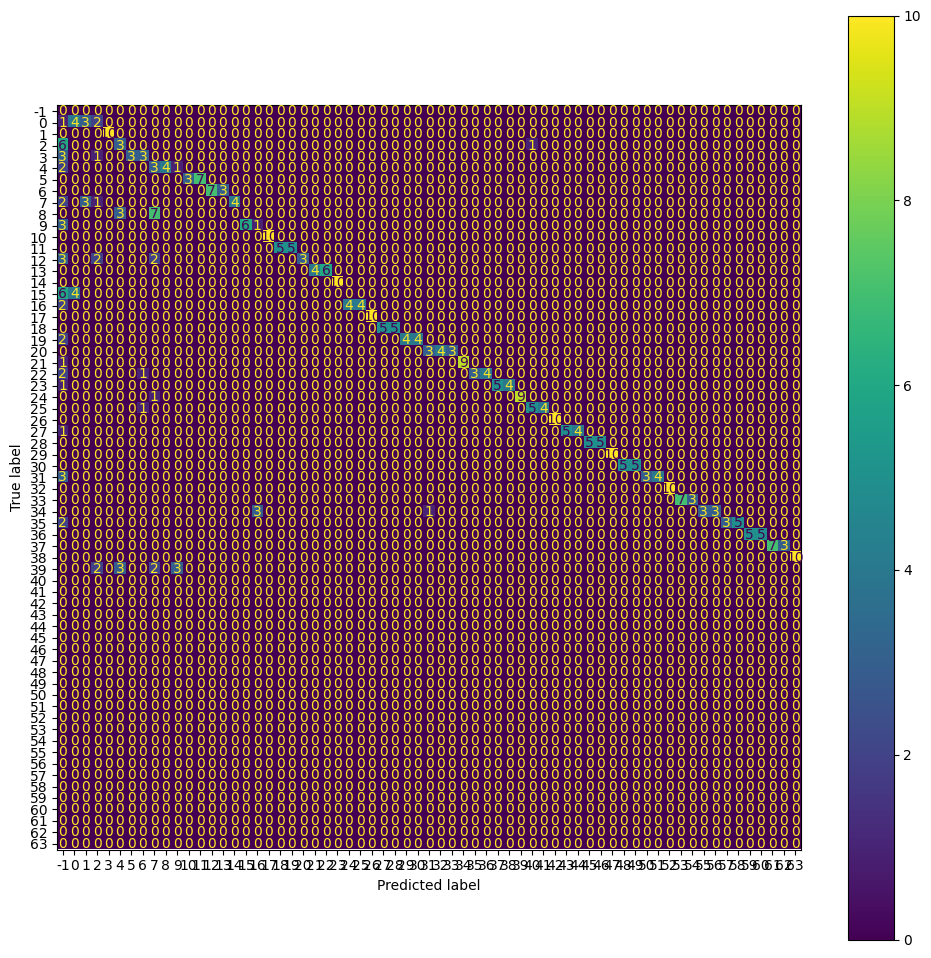

In [30]:
model = DBSCAN(eps=1.9,min_samples=3)
faces_y_pred = model.fit_predict(faces_points)
plt.figure(figsize=(10, 10))
displayCM(faces_y, faces_y_pred)